https://www.youtube.com/watch?v=ZvsH09XGuZ0

Esta forma esta bien para entrenar los modelos basados en tensores, pero no vale para pytorch.

# 1. Descargamos las librerias necesarias para la realización del script


In [1]:
################  TRANSFORMERS ################
!pip  install transformers --quiet
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import Trainer
!pip install transformers[torch] --quiet
!pip install accelerate -U --quiet
################  DATASETS ################
!pip install Datasets --quiet
from datasets import DatasetDict, Dataset
# Librería para montar drive en GoogleColab y descargar el dataset que vamos a usar:
from google.colab import drive  #Montador de drive

In [2]:
# Importamos otros modulos que necesitaremos para nuestra aproximación:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
################  MÉTRICAS ################
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Librería usada para la división del conjunto de datos en 3 conjuntos (Entrenamiento, Validación y Test)
from sklearn.model_selection import train_test_split
import gc

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# 2. Importamos el dataset

In [3]:
# 1.Obtenemos de drive el dataframe con el que vamos a trabajar
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/datasets/01 Exist2021_Esp.csv')
# Cambiamos el nombre de las columnas e eliminamos aquellas que no necesitamos:
columns_to_remove = ['test_case', 'id', 'source','language','task1']
df = df.rename(columns = {"task2": "label"}).drop(columns=columns_to_remove, axis=1)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,text,label
0,Nadie te va a tratar tan bien como un hombre q...,sexual-violence
1,"@lindagisela74 Que rica putita obediente, afor...",stereotyping-dominance
2,@BicireporteraDF Yo lo hice a los 18 años por ...,non-sexist
3,las cosas q sueño son indicios de que yo enrea...,non-sexist
4,"Pero a la niña le gustó desde que lo vió, así ...",non-sexist


In [4]:
# Definiremos un diccionario para poder traduccir las etiquetas o labels que nos devuelva nuestro modelo:
Etiqueta_dato = {}
Dato_Etiqueta = {}

etiquetas = ['non-sexist','sexual-violence', 'stereotyping-dominance',
 'misogyny-non-sexual-violence' ,'ideological-inequality', 'objectification']
for dato, nombre_etiqueta in enumerate(etiquetas):
  Dato_Etiqueta[nombre_etiqueta] = str(dato)
  Etiqueta_dato[str(dato)]= nombre_etiqueta


Etiqueta_dato , Dato_Etiqueta

({'0': 'non-sexist',
  '1': 'sexual-violence',
  '2': 'stereotyping-dominance',
  '3': 'misogyny-non-sexual-violence',
  '4': 'ideological-inequality',
  '5': 'objectification'},
 {'non-sexist': '0',
  'sexual-violence': '1',
  'stereotyping-dominance': '2',
  'misogyny-non-sexual-violence': '3',
  'ideological-inequality': '4',
  'objectification': '5'})

In [5]:
#Cambiamos los valores nominales de sexista y no sexista a valores numéricos
df['label'] = df['label'].replace(['non-sexist','sexual-violence', 'stereotyping-dominance',
 'misogyny-non-sexual-violence' ,'ideological-inequality', 'objectification'],[0,1,2,3,4,5])

In [6]:
#Eliminamos cualquier fila que haya podido quedar en blanco:
df = df.dropna()
df.head()

,text,label
0,Nadie te va a tratar tan bien como un hombre q...,1
1,"@lindagisela74 Que rica putita obediente, afor...",2
2,@BicireporteraDF Yo lo hice a los 18 años por ...,0
3,las cosas q sueño son indicios de que yo enrea...,0
4,"Pero a la niña le gustó desde que lo vió, así ...",0


### 2.1 - *Separamos el dataset en varios conjuntos (Train, Validación y Test)*

In [7]:
# Dividiremos el dataset en el 80% para el entrenamiento, el 10% para el proceso de validation, y un 10% para testear los resultados del modelo.
train_df, valtest_df = train_test_split(df, test_size = 0.2, random_state = 42)
val_df, test_df = train_test_split(valtest_df, test_size = 0.5, random_state = 42)
train_df.shape, val_df.shape, test_df.shape

((9063, 2), (1133, 2), (1133, 2))

In [8]:
train = Dataset.from_pandas(train_df)
validation = Dataset.from_pandas(val_df)
test = Dataset.from_pandas(test_df)

In [9]:
#Lo convertimos en un solo dataset:

tweets = DatasetDict({
  'train': train,
  'val': validation,
  'test': test})
# Dataset.from_pandas genera una columna denominada index_0 qeu debemos eliminar:

tweets = tweets.remove_columns(["__index_level_0__"])

In [10]:
tweets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9063
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 1133
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1133
    })
})

### 3 - Descarga del modelo y su tokenizador:

In [11]:
#Especificamos el modelo a adaptar a nuestro problema:
model_ckpt = "bert-base-cased"
# y descargamos su tokenizador:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
#Debemos definir una función para tokenizar el dataset y que sea gestionable por nuestro modelo:
def tokenizador(batch):
  return tokenizer( batch["text"], padding = True,  max_length=512, truncation = True)

In [13]:
# Para poder aplicarlo al todo el diccionario utilizaremos la función map:
tweets_Encoded = tweets.map(tokenizador, batched = True,batch_size = None )

Map:   0%|          | 0/9063 [00:00<?, ? examples/s]

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

In [14]:
tweets_Encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9063
    })
    val: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1133
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1133
    })
})

In [15]:
#Necesitamos que los objetos sean de tipo torch
tweets_Encoded.set_format("torch", columns = ["label","input_ids", "attention_mask"])

In [16]:
#Debemos comprobar que la ejecucion se vaya a realizar sobre cuda:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
#Obtenemos el modelo con una cabeza de clasificación:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = 6, label2id = Etiqueta_dato, id2label = Dato_Etiqueta).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 3.1 - Definimos las métricas de evaluación y los hiperparámetros:

In [18]:
# 1. Definimos la función de evaluación para calcular tanto el f1 como el accuracy:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average = "weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [19]:
#2. Definimos los hiperparametros para el entrenamiento:
#Empezamos con un batchsize y un número de épocas aleatorio:
batch_size = 8
num_epochs = 3

# Name of the model (to be uploaded to Huggingface)
model_name = f"{model_ckpt}-finetuned-TaskB"

# Specify the path to store the fine-tuned model
path_model = '/content/drive/MyDrive/'

# Training argument
training_args = TrainingArguments(
  output_dir = os.path.join(path_model, model_name),
  num_train_epochs = num_epochs,
  learning_rate = 2e-5,
  per_device_train_batch_size = batch_size,
  per_device_eval_batch_size = batch_size,
  weight_decay = 0.01,
  evaluation_strategy = "epoch",
  load_best_model_at_end = True,
  push_to_hub = False,
  save_strategy = "epoch")

In [20]:
# Creamos el objeto trainer:
trainer = Trainer(
  model = model,
  args = training_args,
  compute_metrics = compute_metrics,
  train_dataset = tweets_Encoded["train"],
  eval_dataset = tweets_Encoded["val"],
  tokenizer = tokenizer)

In [21]:
gc.collect()
torch.cuda.empty_cache()

In [22]:
#5.Entrenamos nuestro modelo:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.261500,1.211743,0.563989,0.499292
2,1.063300,1.101893,0.570168,0.569311
3,0.849500,1.092471,0.597529,0.592416


TrainOutput(global_step=3399, training_loss=1.0756769766699534, metrics={'train_runtime': 2605.4671, 'train_samples_per_second': 10.435, 'train_steps_per_second': 1.305, 'total_flos': 7153983405877248.0, 'train_loss': 1.0756769766699534, 'epoch': 3.0})

### Matriz de Confusión

In [23]:
preds_output = trainer.predict(tweets_Encoded["val"])

In [24]:
preds_output.metrics

{'test_loss': 1.0924711227416992,
 'test_accuracy': 0.5975286849073257,
 'test_f1': 0.5924162423510138,
 'test_runtime': 16.5714,
 'test_samples_per_second': 68.371,
 'test_steps_per_second': 8.569}

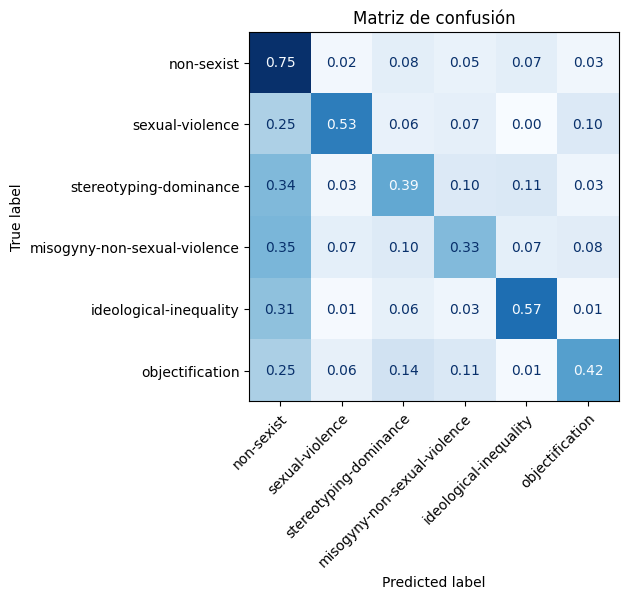

In [25]:
y_preds = np.argmax(preds_output.predictions, axis=1)
cm = confusion_matrix(tweets_Encoded["val"]['label'], y_preds, normalize="true")
labels = ['non-sexist', 'sexual-violence', 'stereotyping-dominance', 'misogyny-non-sexual-violence', 'ideological-inequality', 'objectification']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# Crear una figura y un eje
fig, ax = plt.subplots()
# Plotear la matriz de confusión
disp.plot(cmap="Blues", values_format=".2f", colorbar=False, ax=ax)
# Ajustar las etiquetas de la línea x
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.title("Matriz de confusión")
plt.show()

In [26]:
preds_output = trainer.predict(tweets_Encoded["test"])
preds_output.metrics



{'test_loss': 1.0770667791366577,
 'test_accuracy': 0.6204766107678729,
 'test_f1': 0.6171795854909702,
 'test_runtime': 21.5994,
 'test_samples_per_second': 52.455,
 'test_steps_per_second': 6.574}

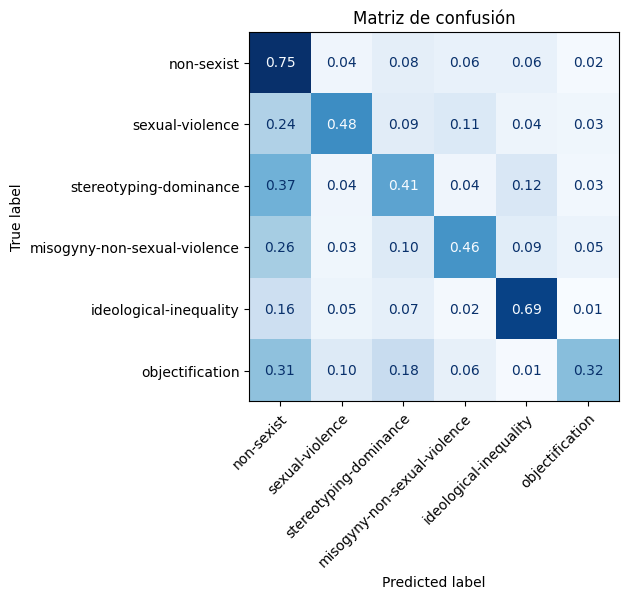

In [27]:
y_preds = np.argmax(preds_output.predictions, axis=1)
cm = confusion_matrix(tweets_Encoded["test"]['label'], y_preds, normalize="true")
labels = ['non-sexist', 'sexual-violence', 'stereotyping-dominance', 'misogyny-non-sexual-violence', 'ideological-inequality', 'objectification']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# Crear una figura y un eje
fig, ax = plt.subplots()
# Plotear la matriz de confusión
disp.plot(cmap="Blues", values_format=".2f", colorbar=False, ax=ax)

# Ajustar las etiquetas de la línea x
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.title("Matriz de confusión")
plt.show()

# Análisis del validation loss

In [28]:
#Análisis de la perdida del modelo:

from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [29]:
tweets_Encoded["val"] = tweets_Encoded["val"].map(forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

In [30]:
def label_int2str(label):
    return Etiqueta_dato[str(label)]

In [31]:
tweets_Encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = tweets_Encoded["val"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [32]:
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.width', None)  # Ancho de la pantalla no limitado
pd.set_option('display.max_colwidth', None)  # Mostrar el texto completo en la
df_test.sort_values("loss", ascending=False).head(10)


,text,label,predicted_label,loss
251,"@AlleyDalley Tuvo que ser un puritano expresando impulsos reprimidos, estoy seguro",sexual-violence,non-sexist,5.833476
1081,"Quién les hizo tanto daño Una habla de #NiUnaMenos o #MeToo, pero a estos batos lo peor que les puede pasar es no tener ligues. Bola de pendejos. https://t.co/5RnZea5J9K",ideological-inequality,non-sexist,5.566880
930,@NinjaSocialist @BynameRose @Ponder_O_Purg @GameOverRos @natsprat3 @annaeck73 @shahjoffe @OustideVoice @EXPELincels @Elfskin7 @CrossBidy @Holdenheim1 @3nigmatic_01 @jools6691 @KRblx123 @blackishmonday @SuperRealScott @beeonroids @GreatMi64424995 @SR_Duncan @j_bbrav0 @TwitchyMac @DredSadie @MgtowRadical @FCDaran @KLKnight81 @AvaGraceVip @Lecanardnoir @Falconer084 @TwenGrit @Kafi @MedusaHypatyPatyPatia @sandsquist@Gen@Gen@Gen@Gen@Gen@G,objectification,non-sexist,5.428539
523,Y voy por un culo así el año que viene https://t.co/n41R03x8u6,objectification,non-sexist,5.390990
467,Los culos gordos son realmente una distracción smh,objectification,non-sexist,5.378636
782,"@ValdebenitoNata Envidia, por favor! Mírate das pena y recuerda yo tengo lo que tú quieres tener. FEMINAZI",ideological-inequality,non-sexist,5.228785
149,"https://t.co/pBzAmUNOO3Esta noticia me rompió el corazón. Piensa mi amigo, y si te pasara a ti o a algún ser querido seguirias siendo un pagafantas? Razón del porqué el #MeToo es una aberración",ideological-inequality,non-sexist,5.166435
221,@_carmela666 Ese culo se merece to,objectification,non-sexist,5.156280
215,@Benholm @hari_fightclub @margaritaevna95 Es una táctica clásica usada contra las mujeres durante milenios para debilitarlas reduciéndolas a objetos. Así que esa es mi desvarío feminista.. No todo el feminismo es malo. Algunas observaciones siguen siendo válidas incluso ahora,objectification,ideological-inequality,5.107974
101,"@TaniaRi71155160 @kondepatula13 Que bueno no es necesario mostrar las tetas, cagar en la calle o andar a raja pela para ser iguales",ideological-inequality,objectification,5.085416


In [33]:
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.width', None)  # Ancho de la pantalla no limitado
pd.set_option('display.max_colwidth', None)  # Mostrar el texto completo en la
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
917,@alegraa10 la polla me menciona todo el mundo en esto jajajajajajaaj,non-sexist,non-sexist,0.022854
204,"@clydesampson @carwat45 @Milliganreports @FaineJon Sí, lo sabemos. #NotAllMen Pero no se trata de eso.",non-sexist,non-sexist,0.023526
328,"cuando deciamos q llevan yendo a saco a por Dayane durante 5 meses xq la ven fuerte y q puede con todo,pero q esta vez habian sobrepasado los limites x la situacion q esta viviendo y q iba a explotar x algun lado? teniamos razon y hoy fue el dia y NO merece y me parte el alma",non-sexist,non-sexist,0.024500
943,"Si encuentras mierda como esta divertida simplemente bloquearme rn por favor. Escondiéndose detrás de un futbolista avi y burlándose de la gente por cómo se ven, qué coño. Lo gracioso es que su frente no es grande en lo más mínimo. Una persona tan vil. https://t.co/5ewXQyCUqH",non-sexist,non-sexist,0.024604
607,@nicelyavocado woaw- eres la persona más hermosa que he visto nunca,non-sexist,non-sexist,0.024792
324,"El destierro violento de personas sin hogar y sus tiendas de campaña está sucediendo en todo el país. Está sucediendo en Minneapolis durante el frígido invierno. Esto habla de la crisis nacional sin hogar impulsado por la mercantilización de la vivienda, pero también los funcionarios locales pueden detener esto. https://t.co/OdDaiJxcEv",non-sexist,non-sexist,0.025037
50,"@FreteLucio No te voy a mentir, la university QUIZÁ se merece un puesto",non-sexist,non-sexist,0.025912
770,"Sesión GOLFA de medianoche! Trilogía LA BLUE GIRL (1995). Live-action de un #hentai. Una orden de guerreras deberán enfrentarse a criaturas armadas de tentáculos sobones. Fx del todo a 100, erotismo, algo de artes marciales y estética 90's por los 4 costados. La mejor: la 2a. https://t.co/xdRIQp4VNR",non-sexist,non-sexist,0.027210
805,"Tim Schafer en #GamerGate: ""Fue una época muy enojada en la cultura del juego y salí de ella bloqueando a 11.000 personas en Twitter... Y por suerte, esas personas se pusieron a moverse para dirigir el gobierno de los Estados Unidos"". https://t.co/Sp5AUNnUya",non-sexist,non-sexist,0.027569
676,@_Laquizee Chill hermano una libra de metal es más pesado que una libra de plumas,non-sexist,non-sexist,0.027657


In [34]:
model.save_pretrained(
  os.path.join(path_model, 'BERT-finetuned-TaskB'))
tokenizer.save_pretrained(
    os.path.join(path_model, 'BERT-finetuned-TaskB'))

('/content/drive/MyDrive/BERT-finetuned-TaskB/tokenizer_config.json',
 '/content/drive/MyDrive/BERT-finetuned-TaskB/special_tokens_map.json',
 '/content/drive/MyDrive/BERT-finetuned-TaskB/vocab.txt',
 '/content/drive/MyDrive/BERT-finetuned-TaskB/added_tokens.json',
 '/content/drive/MyDrive/BERT-finetuned-TaskB/tokenizer.json')

## Prueba para verificar clasificación de categorías:

In [35]:
#Obtenemos de drive el dataframe con el que vamos a trabajar
drive.mount('/content/drive')
df2 = pd.read_csv('/content/drive/MyDrive/Datasets a limpio /EXIST 2021 dataset_esp.csv')
# Cambiamos el nombre de las columnas e eliminamos aquellas que no necesitamos:
columns_to_remove = ['test_case', 'id', 'source','language','task1']
df2 = df2.rename(columns = {"task2": "label"}).drop(columns=columns_to_remove, axis=1)
df2.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,text,label
0,Nadie te va a tratar tan bien como un hombre que te lo quiere meter por primera vez.,sexual-violence
1,"@lindagisela74 Que rica putita obediente, afortunado tu marido de tener una mujer como tú, saludos",stereotyping-dominance
2,@BicireporteraDF Yo lo hice a los 18 años por la carretera libre a Veracruz y ahora hay más carreteras veras que si puedes mujer,non-sexist
3,"las cosas q sueño son indicios de que yo enrealidad soy una lesbiana reprimida, no tengo ninguna duda d esto",non-sexist
4,"Pero a la niña le gustó desde que lo vió, así que me le dije, hola bien y tú? Ese día sólo podía ver un hombre guapo, moreno (como me gustan) con una barba que rodeaba su boca tan perfecta y unos ojazos que wow. Hasta las manos le vi ajjaja por que si me fijo en eso",non-sexist


In [36]:
valores_unicos = df2['label'].unique()
print(valores_unicos)


['sexual-violence' 'stereotyping-dominance' 'non-sexist'
 'misogyny-non-sexual-violence' 'ideological-inequality' 'objectification']


In [37]:
#Cambiamos los valores nominales de sexista y no sexista a valores numéricos
df2['label'] = df2['label'].replace(['non-sexist','sexual-violence', 'stereotyping-dominance',
 'misogyny-non-sexual-violence' ,'ideological-inequality', 'objectification'],[0,1,2,3,4,5])

In [38]:
df2.head()

,text,label
0,Nadie te va a tratar tan bien como un hombre que te lo quiere meter por primera vez.,1
1,"@lindagisela74 Que rica putita obediente, afortunado tu marido de tener una mujer como tú, saludos",2
2,@BicireporteraDF Yo lo hice a los 18 años por la carretera libre a Veracruz y ahora hay más carreteras veras que si puedes mujer,0
3,"las cosas q sueño son indicios de que yo enrealidad soy una lesbiana reprimida, no tengo ninguna duda d esto",0
4,"Pero a la niña le gustó desde que lo vió, así que me le dije, hola bien y tú? Ese día sólo podía ver un hombre guapo, moreno (como me gustan) con una barba que rodeaba su boca tan perfecta y unos ojazos que wow. Hasta las manos le vi ajjaja por que si me fijo en eso",0


In [39]:
# Definiremos un diccionario para poder traduccir las etiquetas o labels que nos devuelva nuestro modelo:
Etiqueta_dato = {}
Dato_Etiqueta = {}

etiquetas = ['non-sexist','sexual-violence', 'stereotyping-dominance',
 'misogyny-non-sexual-violence' ,'ideological-inequality', 'objectification']
for dato, nombre_etiqueta in enumerate(etiquetas):
  Dato_Etiqueta[nombre_etiqueta] = str(dato)
  Etiqueta_dato[str(dato)]= nombre_etiqueta


Etiqueta_dato , Dato_Etiqueta

({'0': 'non-sexist',
  '1': 'sexual-violence',
  '2': 'stereotyping-dominance',
  '3': 'misogyny-non-sexual-violence',
  '4': 'ideological-inequality',
  '5': 'objectification'},
 {'non-sexist': '0',
  'sexual-violence': '1',
  'stereotyping-dominance': '2',
  'misogyny-non-sexual-violence': '3',
  'ideological-inequality': '4',
  'objectification': '5'})

In [40]:
def label_int2str(label):
    return Etiqueta_dato[str(label)]

In [41]:
df2["label_name"] = df2["label"].apply(label_int2str)
df2.head()

,text,label,label_name
0,Nadie te va a tratar tan bien como un hombre que te lo quiere meter por primera vez.,1,sexual-violence
1,"@lindagisela74 Que rica putita obediente, afortunado tu marido de tener una mujer como tú, saludos",2,stereotyping-dominance
2,@BicireporteraDF Yo lo hice a los 18 años por la carretera libre a Veracruz y ahora hay más carreteras veras que si puedes mujer,0,non-sexist
3,"las cosas q sueño son indicios de que yo enrealidad soy una lesbiana reprimida, no tengo ninguna duda d esto",0,non-sexist
4,"Pero a la niña le gustó desde que lo vió, así que me le dije, hola bien y tú? Ese día sólo podía ver un hombre guapo, moreno (como me gustan) con una barba que rodeaba su boca tan perfecta y unos ojazos que wow. Hasta las manos le vi ajjaja por que si me fijo en eso",0,non-sexist


# Vamos a revisar el conjunto de datos que tenemos

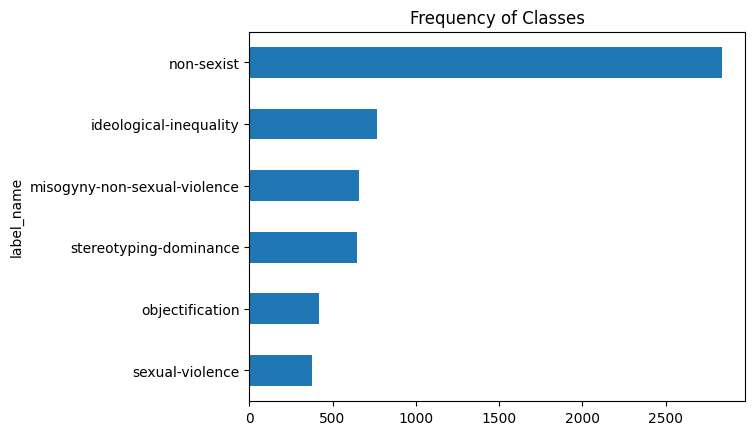

In [42]:
import matplotlib.pyplot as plt

df2["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

Observamos que el dataset no está balanceado. Ya que los mensajes no misogenos superan en creces al resto de las tipologias.

Para poder gestionar datasets que no estén balanceados se podría llevar a cabo las siguientes técnicas:


1.   Randomly oversample the minority class.
2.   Randomly undersample the majority class.

Pero esto queda fuera del scope de nuestro trabajo (Posible acciones futuras).





# Revisar como de Largos son los Tweets , para evitar pasarnos del maximum context size

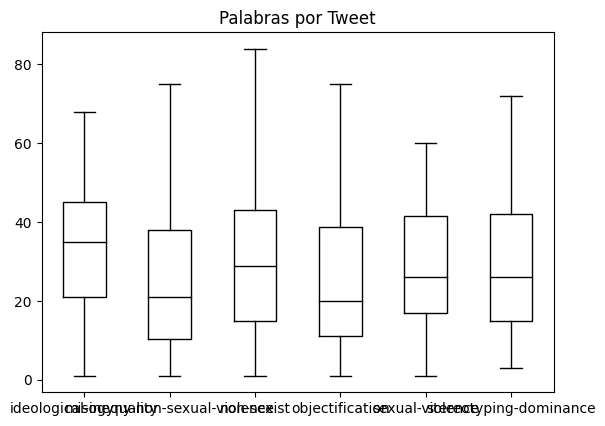

In [43]:
df2["Palabras por Tweet"] = df2["text"].str.split().apply(len)
df2.boxplot("Palabras por Tweet", by="label_name", grid=False,
          showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [44]:
tokenizer.model_max_length

512